##                                              Solar Power Generation Forecasting

### Problem Statement: 
Using the provided solar plant dataset (with features such as AMBIENT_TEMPERATURE.MODULE_TEMPERATURE, IRRADIATION, AC_POWER, DC_POWER and DAILY_YEILD and TOTAL_YEILD Etc), develop a forecasting model to predict future solar power output. The goal is to use historical weather and production data to estimate how much electricity the plant will generate for the particular Temprature and Irradiation. 


### Importing Required Libraries

In [5]:
import numpy as np # To perform numerical operations
import pandas as pd # To do data manipulation and analysis
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For advanced Data visualizations
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import train_test_split # For splitting dataset into training and testing set
from sklearn.linear_model import LinearRegression # For Model Selection
from sklearn.ensemble import RandomForestRegressor # Model Selection for Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # To Evaluate Model's Performance
from datetime import datetime  # To handle time based features 
import joblib # For saving and Loading the Trained Model

### Dataset Overview

#### Dataset Details -1
* **Dataset Name** : **Plant1_Generation_Data**
* **Source** : https://www.kaggle.com/code/pythonafroz/solar-power-generation-forecast/input
* **File Format** : .csv

#### Dataset Description
The Plant_1_Generation_Data dataset contains time-series records of solar energy production from a utility-scale solar power plant. Each row corresponds to the performance data captured at a specific timestamp from one of the plant’s inverters. The dataset is essential for analyzing energy generation patterns, evaluating inverter performance, and building forecasting models.

#### Feature Description
* **DATE_TIME** : Timestamp of the measurement
* **PLANT_ID** : Unique Identifier for the solar plant
* **SOURCE_KEY** : Unique Identifier for each inverter unit
* **DC_POWER** : Direct Current Power output from the inverter in Watts
* **AC_POWER** : Alternating Current Power output from the inverter in Watts
* **DAILY_YEILD** : Energy generated so far during the current day in kWh
* **TOTAL_YEILD** : Cumulative energy output of the inverter since installatio

#### Dataset Details -2

* **Dataset Name** : **Plant1_Weather_Sensor_Data**
* **Source** : Kaggle.com
* **File Format** : .csv

#### Dataset Description
The Plant 1 Weather Sensor Data dataset contains meteorological information collected from weather sensors installed at the solar power plant. This data captures the environmental conditions that directly influence solar energy generation. Each row represents weather readings recorded at a specific timestamp from the plant’s weather monitoring systems.

#### Feature Description
* **DATE_TIME** : Timestamp of the weather measurement
* **PLANT_ID** : Unique Identifier for the solar plant
* **SOURCE_KEY** : Unique identifier for the weather sensor unit
* **AMBIENT_TEMPERATURE** : The surrounding air temperature in degrees Celsius
* **MODULE_TEMPERATURE** : The temperature at the surface of the solar panel in degrees Celsius
* **IRRADIATION** : The intensity of solar radiation measured at the plant in W/m²n kWh


#### Loading the Dataset

In [6]:
#Loading the plant 1 generation and Weather Sensor Data
generation_data = pd.read_csv('Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

#### Explore and Understand the Data

In [7]:
generation_data.head(5) # viewing the first 5 rows of the Geneation dataset

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [9]:
weather_data.head(5) # viewing the first 5 rows of the Weather Sensor Dataseted

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


#### Merging Generation and Weather Sensor Dataset
For Solar Power Generation Forecasting we are going to merge the Generation and Weather Sensor Data based on the DATE_TIME Filed.

##### Converting DATE_TIME to datetime format

In [10]:
# before merging the datasets we ne to convert date time format for proper time alignement

generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'], dayfirst=True) # Parsing the date string in the format of Day/month/year
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])

##### Aggregating Generation and Weather Sensor Data
Here we are going to aggregate the Generation data. This aggregated data can lead to more accurate forecasts by reducing the impact of 
individual inverter or  plant variability.And it often easier to analyze and visualize, enabling faster insights and decision-making. And also it can help grid operators manage energy supply and demand more effectively. 

In [11]:
# Aggregating Generation Data
generation_agg = generation_data.groupby('DATE_TIME').agg({
    'DC_POWER':'sum', #calculating the sum of DC_Power
    'AC_POWER':'sum', #calculating the sum of AC_POWER
    'DAILY_YIELD' : 'mean', #calculating the average of DAILY_YEILD
    'TOTAL_YIELD' : 'mean' #calculating the average of TOTAL_YIELD
}).reset_index() # Used to control and manage the structure of a Dataframe's Index

In [12]:
generation_agg

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,0.0,0.0,0.000000,6.837223e+06
1,2020-05-15 00:15:00,0.0,0.0,0.000000,6.837223e+06
2,2020-05-15 00:30:00,0.0,0.0,0.000000,6.837223e+06
3,2020-05-15 00:45:00,0.0,0.0,0.000000,6.837223e+06
4,2020-05-15 01:00:00,0.0,0.0,0.000000,6.852802e+06
...,...,...,...,...,...
3153,2020-06-17 22:45:00,0.0,0.0,5889.590909,7.097398e+06
3154,2020-06-17 23:00:00,0.0,0.0,5889.590909,7.097398e+06
3155,2020-06-17 23:15:00,0.0,0.0,5889.590909,7.097398e+06
3156,2020-06-17 23:30:00,0.0,0.0,5889.590909,7.097398e+06


In [13]:
# aggregating Weather Sensor Data
weather_agg = weather_data.groupby('DATE_TIME').agg({
    'AMBIENT_TEMPERATURE' : 'mean', #calculating average AMBIENT_TEMPERATURE
    'MODULE_TEMPERATURE' : 'mean', #calculating average MODULE_TEMPERATURE
    'IRRADIATION' : 'mean' #calculating average IRRADIATION
}).reset_index()

In [14]:
weather_agg

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,24.621525,22.165423,0.0
...,...,...,...,...
3177,2020-06-17 22:45:00,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,21.969495,20.734963,0.0


##### Merging both datasets on DATE_TIME

In [15]:
Final_Data = pd.merge(generation_agg,weather_agg,on='DATE_TIME',how='inner') #how carries other values like outer, left and right

In [16]:
# final data after merging generation and weather sensor data
Final_Data 

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000000,6.837223e+06,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.000000,6.837223e+06,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.000000,6.837223e+06,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.000000,6.837223e+06,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.000000,6.852802e+06,24.621525,22.165423,0.0
...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,0.0,0.0,5889.590909,7.097398e+06,22.150570,21.480377,0.0
3153,2020-06-17 23:00:00,0.0,0.0,5889.590909,7.097398e+06,22.129816,21.389024,0.0
3154,2020-06-17 23:15:00,0.0,0.0,5889.590909,7.097398e+06,22.008275,20.709211,0.0
3155,2020-06-17 23:30:00,0.0,0.0,5889.590909,7.097398e+06,21.969495,20.734963,0.0


In [17]:
# Savind the Merged Dataset
Final_Data.to_csv('Plant1_Merged_Dataset.csv',index=False)

In [18]:
# Checking the dimension of the dataset
Final_Data.shape

(3157, 8)

In [19]:
# checking the size of the dataset
Final_Data.size

25256

In [20]:
#exploring the datatypes
Final_Data.dtypes

DATE_TIME              datetime64[ns]
DC_POWER                      float64
AC_POWER                      float64
DAILY_YIELD                   float64
TOTAL_YIELD                   float64
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
dtype: object

In [21]:
# exploring the statistical information of a dataset
Final_Data.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3157,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000
mean,2020-06-01 06:41:41.298701568,68560.019625,6704.830534,3324.402716,6.977422e+06,25.560257,31.175453,0.230103
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.635010e+06,20.398505,18.140415,0.000000
25%,2020-05-23 23:15:00,0.000000,0.000000,4.124188,6.917337e+06,22.739895,21.130249,0.000000
50%,2020-06-01 12:30:00,8430.196429,814.880357,3009.619318,6.981686e+06,24.680324,24.801971,0.027748
75%,2020-06-09 18:00:00,140409.892856,13752.112500,6094.517045,7.045256e+06,27.941221,41.449481,0.451576
max,2020-06-17 23:45:00,298937.785710,29150.212499,8807.727273,7.097398e+06,35.252486,65.545714,1.221652
std,NaN,88055.843520,8604.217954,3045.292432,7.513782e+04,3.351059,12.272685,0.301348


In [22]:
# exploring null values
Final_Data.isnull().sum()

DATE_TIME              0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

#### Applying Correlation Heat map for Final Data
Correlation heat maps are used to understand the relationships between variables. To identify the important features. 
To detect the redunduncy and multicollinearity and also useful for quick visual summary of the dataset.

In [23]:
correlation_matrix = Final_Data.corr(numeric_only = True) # calculating the pairwise correlation b/w all numerical columns

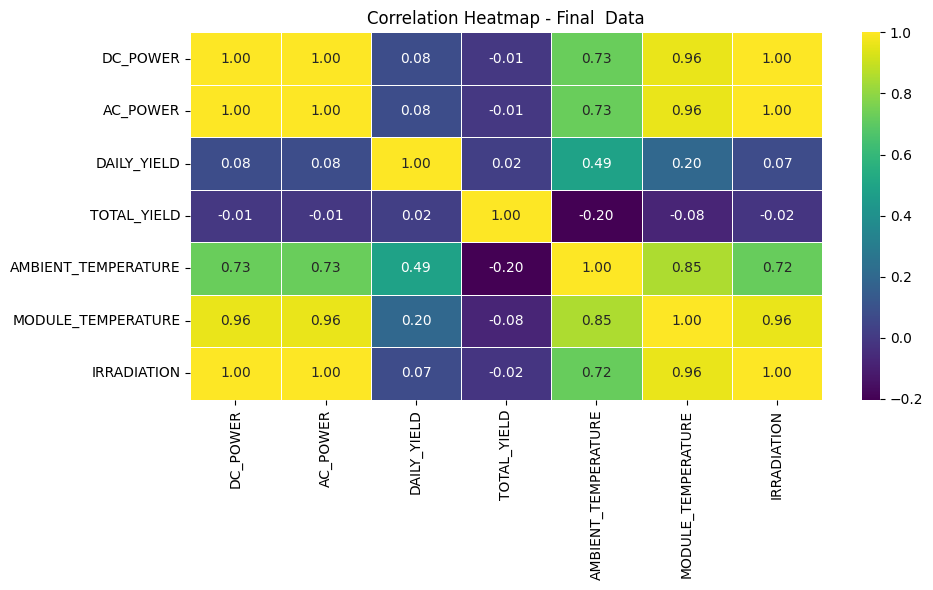

In [24]:
plt.figure(figsize=(10, 6)) # sets the figure size as 10 inches width and 6 inches tall
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5) 
plt.title("Correlation Heatmap - Final  Data")
plt.tight_layout() # used to prevent the overlapping in the figure area
plt.show() # used to visualize the figure

From the above correlation heatmap we can clearly understand that the high correlations near 1+ shows that irradiation is the dominant factor
driving power production and module temperature. The Moderate positive correlations around 0.5 to 0.8 shows more energy produced on sunny days based on the  AMBIENT_TEMPERATURE with DC_POWER / AC_POWER and DAILY_YIELD. The weak (0) or negative (-) values shows no correlation and it's not statistically meaningful.

#### Plotting Feature Distrbutions
Feature distribution is very helpful to understand how each variable in the dataset is spread. 
Here we are going to plot the feature distributions for daytime data to include the non-zero values in the distributions.

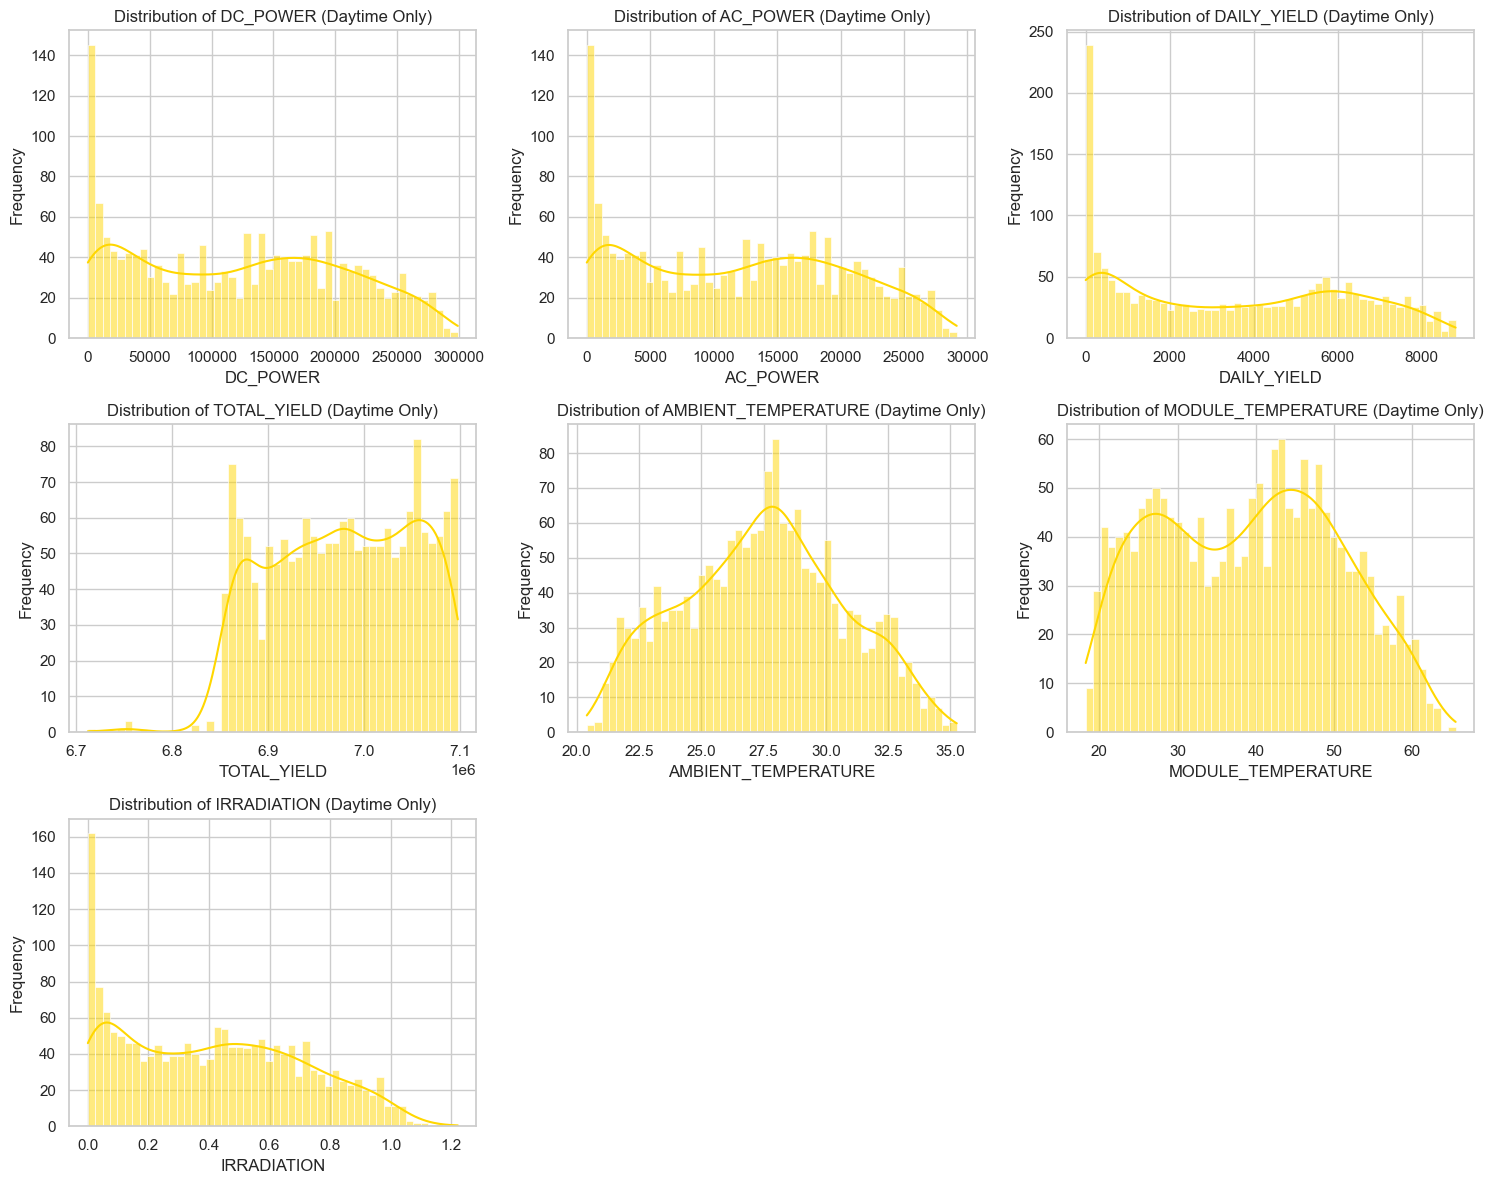

In [25]:
daytime_data = Final_Data[Final_Data['IRRADIATION']>0] # filtering only the day time data by setting Irridation > 0

numeric_columns = daytime_data.select_dtypes(include=['float64', 'int64']).columns # selecting only numeric columns from the dataframe

sns.set(style="whitegrid")

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(daytime_data[col], kde=True, bins=50, color='gold')
    plt.title(f'Distribution of {col} (Daytime Only)')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**A short summary From the above Feature Distribution**
* **DC_POWER & AC_POWER** : Both show right-skewed distributions, indicating most readings are at lower power levels with fewer high-output instances.
* **DAILY_YEILD** : Right-skewed distribution suggests many days with lower energy production, potentially due to shorter daylight hours or cloudy weather conditions.
* **TOTAL_YEILD** : Displays a narrow range with a nearly uniform spread.
* **AMBIENT_TEMPERATURE** : Approximately normal distribution centered around 27–28°C.
* **MODULE_TEMPERATURE** : Bimodal distribution shows distinct heating patterns
* **IRRADIATION** : Strongly right-skewed, with a high frequency of low values.

#### Handling Outliers
Outliers are data points that significantly deviate from other observations in a dataset. They can arise due to measurement errors, data entry mistakes, or genuinely represent extreme values. Here we are going to use the Box Plot for visualizing the outliers.

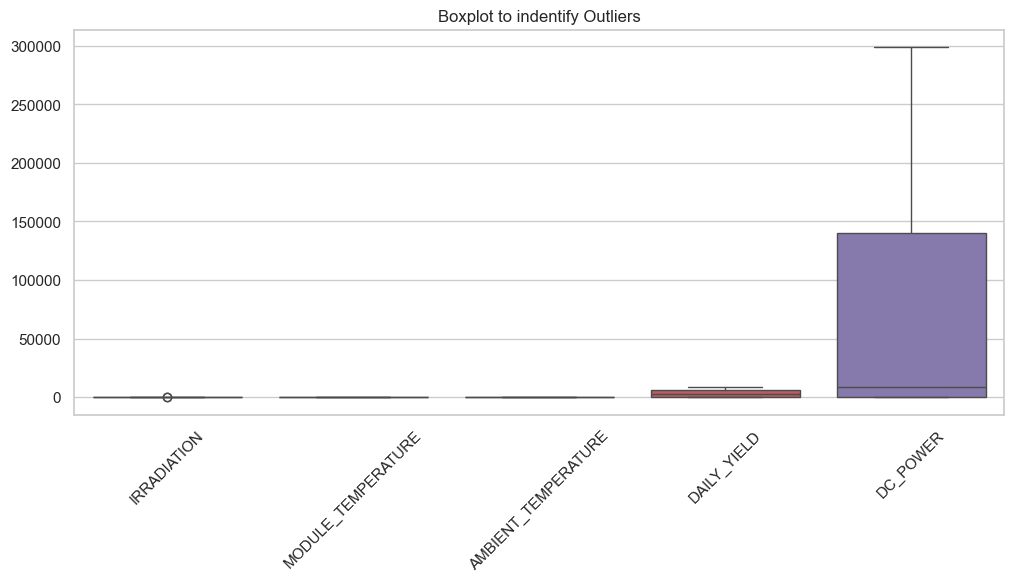

In [26]:
# Using these features to visualize the box plot to identify the outliers in a dataframe
Features = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER'
]
plt.figure(figsize=(12, 5))
sns.boxplot(data=Final_Data[Features])
plt.title("Boxplot to indentify Outliers")
plt.xticks(rotation=45)
plt.show()

The above boxplot does indicates outliers specifically in the IRRADIATION and DC_POWER variables. Now we are going to apply the Interquartile Range (IQR) method to remove those outliers.

In [27]:
# creating a copy to avoid the changes in original data
Data_Clean = Final_Data.copy()

In [28]:
#applying IQR method to remove the outliers
for col in Features:
    Q1 = Data_Clean[col].quantile(0.25)
    Q3 = Data_Clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Data_Clean = Data_Clean[(Data_Clean[col] >= lower_bound) & (Data_Clean[col] <= upper_bound)]

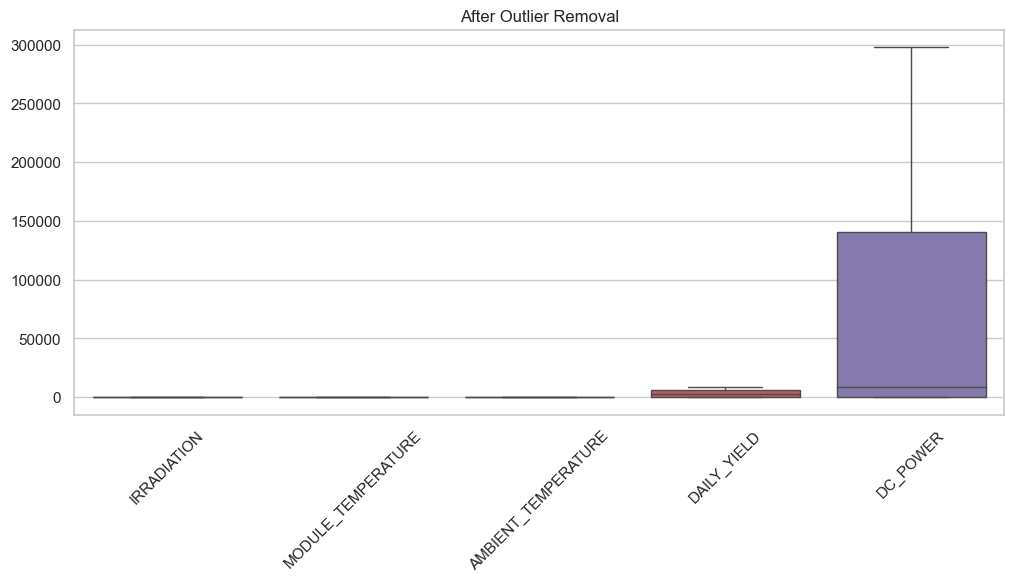

In [29]:
#Visualizing the box plot after removing the outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=Data_Clean[Features])
plt.title("After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

This updated box plot shows that most of the variables IRRADIATION, MODULE_TEMPERATURE, AMBIENT_TEMPERATURE, and DAILY_YIELD no longer have visible outliers. However AC_POWER still seems to have outliers, as indicated by data points extending beyond the whiskers. As we already applied IQR method to remove maximum of outliers from various features. Let's apply a time series chart for DC_POWER variable to check the data trends. This may help us to undertand whether these outliers are natural high values depending on the context of our dataset.

In [30]:
Final_Data

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000000,6.837223e+06,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.000000,6.837223e+06,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.000000,6.837223e+06,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.000000,6.837223e+06,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.000000,6.852802e+06,24.621525,22.165423,0.0
...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,0.0,0.0,5889.590909,7.097398e+06,22.150570,21.480377,0.0
3153,2020-06-17 23:00:00,0.0,0.0,5889.590909,7.097398e+06,22.129816,21.389024,0.0
3154,2020-06-17 23:15:00,0.0,0.0,5889.590909,7.097398e+06,22.008275,20.709211,0.0
3155,2020-06-17 23:30:00,0.0,0.0,5889.590909,7.097398e+06,21.969495,20.734963,0.0


Here we are setting the TIMESTAMP as the Index for proper time-series visualization. As we already converted the TIMESTAMP in to DATE_TIME Format here we are going to use the merged Final_Data DATE_TIME for setting the Index.

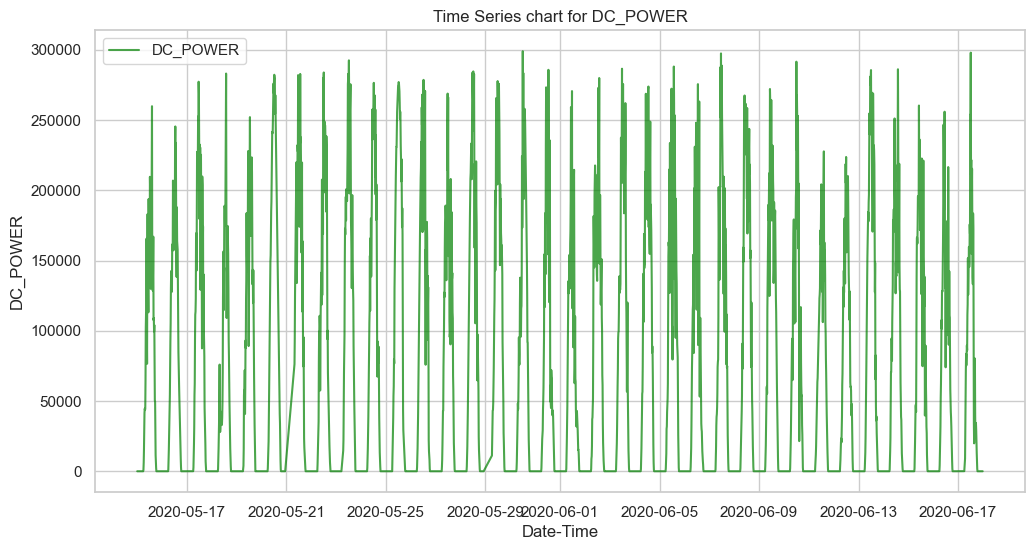

In [31]:
# Set DATE_TIME as the index
Final_Data.set_index('DATE_TIME', inplace=True)
Final_Data.sort_index(inplace=True)

# Plot DC_POWER time series
plt.figure(figsize=(12, 6))
plt.plot(Final_Data.index, Final_Data['DC_POWER'], color="green", alpha=0.7, label="DC_POWER")

plt.title("Time Series chart for DC_POWER")
plt.xlabel("Date-Time")
plt.ylabel("DC_POWER")
plt.legend()
plt.show()

**Observation from the above Time Series plot**
The time series plot represent maximum solar generation during day time. The peak values are very stable between 250000 to 30000. 
So the high values in DC_POWER are not outliers. They are natural and expected values.

#### Feature Scaling
It is a technique used in data preprocessing to normalize or standardize numerical variables so they have comparable scales. This ensures that machine learning models treat all features equally, preventing bias toward higher-magnitude values.
Here we are applying Z_Score scalling technique. Z-score Scaling transforms features by subtracting the mean and dividing by the standard deviatiaion. 

In [32]:
features_to_scale = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER',
    'AC_POWER' 
]
scaler = StandardScaler()
Final_Data_standardized = Final_Data.copy()
Final_Data_standardized[features_to_scale] = scaler.fit_transform(Final_Data[features_to_scale])

print(Final_Data_standardized.head())

                     DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
DATE_TIME                                                            
2020-05-15 00:00:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:15:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:30:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:45:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 01:00:00  -0.77872 -0.779373    -1.091826  6.852802e+06   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
DATE_TIME                                                                  
2020-05-15 00:00:00            -0.112203           -0.677868    -0.763699  
2020-05-15 00:15:00            -0.141968           -0.685679    -0.763699  
2020-05-15 00:30:00            -0.186390           -0.699481    -0.763699  
2020-05-15 00:45:00            -0.213138           -0.718343    -0.763699  
2020-05-15 01:00:00            -0.280174           -0

#### Feature Selection

In [33]:
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'] # Input features or Independant Features
target = 'DC_POWER' # Target Varibale or Dependent Variable

X = Final_Data_standardized[features]
y = Final_Data_standardized[target]

#### Data Splitting
Data Splitting for the Training and Testing Purpose.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Selection and Model Building
Here we are applying the Linear Regression Model. The important key notes for using Linear Regression is as follows. Simplicity & Interpretability,
Fast Computation, Captures Linear Relationships and It's a Baseline Model.

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [36]:
# Making predictions with the test data
y_pred = model.predict(X_test)
y_pred

array([-7.61336851e-01, -7.65015051e-01, -7.60749105e-01,  1.61004774e+00,
        1.18460786e+00, -7.58862676e-01,  3.53661036e-02, -7.64905416e-01,
       -7.54052793e-01, -7.63108933e-01,  2.15742763e+00, -7.35252965e-01,
       -7.63777815e-01, -7.66959544e-01, -7.63405458e-01, -7.65031696e-01,
        1.23122920e+00,  1.70765851e+00, -7.65288082e-01, -7.63013684e-01,
       -7.64245056e-01, -7.58254547e-01, -7.63202567e-01,  1.49294091e+00,
       -7.64273578e-01, -7.42817035e-01,  2.49015386e-01,  6.92637933e-01,
       -7.58119324e-01,  4.57971588e-01,  2.07663481e+00, -7.62742060e-01,
       -7.62484014e-01,  1.21851646e+00,  5.10716833e-01, -7.66405335e-01,
       -7.63271000e-01, -7.65367098e-01,  2.39760625e-01,  1.08704898e+00,
       -4.03614080e-02, -7.64300131e-01, -7.64011552e-01, -7.60948727e-01,
        2.01813664e+00,  1.75926046e+00,  1.54401009e+00, -7.64799872e-01,
        1.04527325e+00, -7.60920774e-01, -7.58197427e-01, -7.64143984e-01,
       -3.22100648e-01,  

#### Applying Evaluation Metrics to check model's performance

In [37]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)

MSE: 0.00583339443101152
R² Score: 0.9939010484064352


#### Visualizing the Actual Value and the Predicted Value

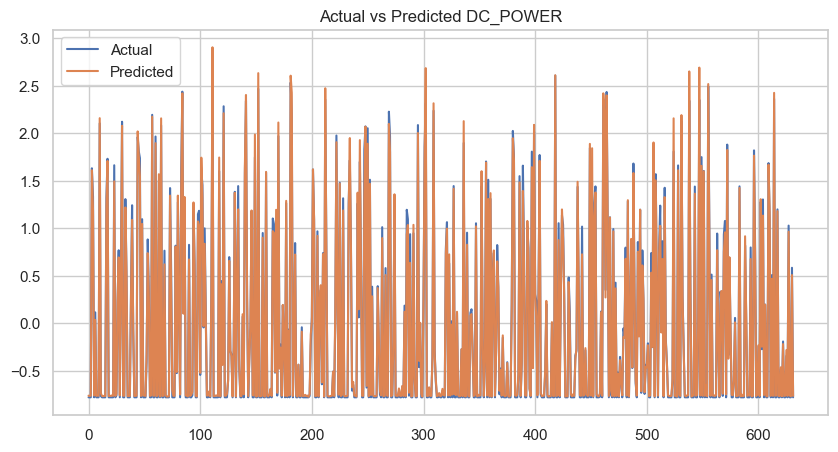

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted DC_POWER")
plt.legend()
plt.show()

#### Making Predictions of Solar Power Generation for the User's Input

In [39]:
# features used in model training
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# user input
user_input = []
print("Enter values for the following features:")

for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Reshape to match scaler input
input_array = np.array(user_input).reshape(1, -1)

# Scale using a new scaler trained only on those 3 features
scaler = StandardScaler().fit(X_train)  
scaled_input = scaler.transform(input_array)

# Predict
predicted_power = model.predict(scaled_input)

print(f"\n⚡ Predicted DC Power: {predicted_power[0]:.4f}")


Enter values for the following features:

⚡ Predicted DC Power: 22.2161


c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#### Saving the Model using JobLib

In [40]:
joblib.dump(model, 'solar_Power_eneration_model.pkl')

['solar_Power_eneration_model.pkl']

#### Applying Random Forest Regressor for Solar Power Generation Forecasting

Here we are going to predict the solar power generation based on the input features Irradiation, Module Temperature, Ambient Temperature including day and time.

In [41]:
print(Final_Data.index)

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:15:00',
               '2020-05-15 00:30:00', '2020-05-15 00:45:00',
               '2020-05-15 01:00:00', '2020-05-15 01:15:00',
               '2020-05-15 01:30:00', '2020-05-15 01:45:00',
               '2020-05-15 02:00:00', '2020-05-15 02:15:00',
               ...
               '2020-06-17 21:30:00', '2020-06-17 21:45:00',
               '2020-06-17 22:00:00', '2020-06-17 22:15:00',
               '2020-06-17 22:30:00', '2020-06-17 22:45:00',
               '2020-06-17 23:00:00', '2020-06-17 23:15:00',
               '2020-06-17 23:30:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=3157, freq=None)


In [42]:
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3157 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DC_POWER             3157 non-null   float64
 1   AC_POWER             3157 non-null   float64
 2   DAILY_YIELD          3157 non-null   float64
 3   TOTAL_YIELD          3157 non-null   float64
 4   AMBIENT_TEMPERATURE  3157 non-null   float64
 5   MODULE_TEMPERATURE   3157 non-null   float64
 6   IRRADIATION          3157 non-null   float64
dtypes: float64(7)
memory usage: 197.3 KB


In [43]:
Final_Data.reset_index(inplace=True)

In [44]:
### Extracting the important features to predict the power generation based on time
Final_Data['HOUR'] = Final_Data['DATE_TIME'].dt.hour
Final_Data['DAY'] = Final_Data['DATE_TIME'].dt.day
Final_Data['MONTH'] = Final_Data['DATE_TIME'].dt.month
Final_Data['DAY_OF_WEEK'] = Final_Data['DATE_TIME'].dt.dayofweek

#### Feature Selection

In [45]:
features = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'HOUR',
    'DAY',
    'MONTH',
    'DAY_OF_WEEK'
]
target = 'DC_POWER'

X = Final_Data[features]
y = Final_Data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Data Splitting for Training and Testing

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Model Selection and Model Building

In [47]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Making Prediction with the Test Data

In [48]:
y_pred = model.predict(X_test)
y_pred

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.13984459e+05,
       1.71347895e+05, 0.00000000e+00, 7.75743875e+04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.54993072e+05, 9.99260298e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.86129456e+05, 2.18479615e+05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01764464e+05,
       0.00000000e+00, 1.63560446e+03, 9.15781621e+04, 1.37487156e+05,
       0.00000000e+00, 1.15783820e+05, 2.50089557e+05, 0.00000000e+00,
       0.00000000e+00, 1.88075431e+05, 1.15004489e+05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.66839072e+04, 1.76244438e+05,
       7.05985498e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.37020711e+05, 2.25672828e+05, 2.00723275e+05, 0.00000000e+00,
       1.64454482e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.06339086e+04, 1.43689167e+05, 9.44253924e+04, 0.00000000e+00,
      

#### Applying Evaluation Metrics for Validating Model's Performance

In [49]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)

MSE: 27981485.071320172
R² Score: 0.9962257920253692


#### Making Predictions with the User Input

In [50]:
#getting the input from the user
date_str = input("Enter date and time (YYYY-MM-DD HH:MM): ")
IRRADIATION = float(input("Enter IRRADIATION: "))
MODULE_TEMPERATURE = float(input("Enter MODULE TEMPERATURE (°C): "))
AMBIENT_TEMPERATURE = float(input("Enter AMBIENT TEMPERATURE (°C): "))

#parsing Date time and Extracting the input features
input_time = datetime.strptime(date_str, "%Y-%m-%d %H:%M")
hour = input_time.hour
day = input_time.day
month = input_time.month
day_of_week = input_time.weekday() 

#creating Input Data Frame
input_df = pd.DataFrame([[ IRRADIATION, MODULE_TEMPERATURE, AMBIENT_TEMPERATURE, hour, day, month, day_of_week]],
            columns=['IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','HOUR','DAY','MONTH','DAY_OF_WEEK'])

#Scaling the user input
input_scaled = scaler.transform(input_df)

#making prediction with trained model
predicted_dc_power = model.predict(input_scaled)

#printing the predicted result
print(f"\n⚡ Predicted DC Power: {predicted_dc_power[0]:.4f}")

ValueError: time data '12-05-2023' does not match format '%Y-%m-%d %H:%M'

#### Saving the Model with Joblib

In [51]:
joblib.dump(model, 'solar_Power_eneration_Forecasting_model.pkl')

['solar_Power_eneration_Forecasting_model.pkl']